# Normal distribution 

The simplest model: the Normal distribution. It is used as a basic components in many more complex models.

In [1]:
using Pkg
Pkg.activate("../");

using LinearAlgebra
using Plots
using Random
using AutoGrad

import ExpFamilyDistributions
const EFD = ExpFamilyDistributions

using Revise
using BayesianModels

# Plotting function
include("plotting.jl");

  Activating environment at `~/Repositories/BayesianModels.jl/Project.toml`
┌ Info: Precompiling BayesianModels [1400088c-90aa-43b9-ae43-7211fec07595]
└ @ Base loading.jl:1317


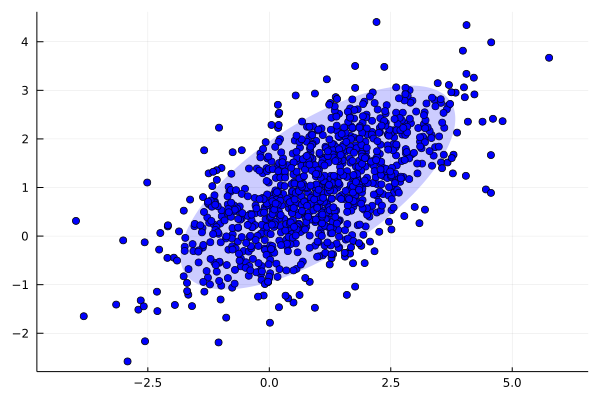

In [2]:
T = Float64
μₓ = T[1, 1] 
Σₓ = T[2 1; 1.0  1.1]
#Σₓ = T[2 0; 0  1.1]

function draw(n, μ, Σ)
    L = cholesky(Σ).L
    hcat([μ + L*randn(T, 2) for i in 1:n]...)
end


X = draw(1000, μₓ, Σₓ)
p = plot(legend = false, aspect_ratio = 1)
scatter!(X[1,:], X[2,:], color = :blue)
plotnormal!(μₓ, Σₓ, σ = 2, color = :blue, linewidth = 0, fillalpha = 0.2)

In [3]:
D = 2
model_full = BayesianModels.Normal(D, pstrength = 1)
model_diag = BayesianModels.NormalDiag(D, pstrength = 1)

BayesianModels.NormalDiagIndependentParams{2} (
  (μ): BayesianParameter{ExpFamilyDistributions.NormalDiag{ExpFamilyDistributions.DefaultParameter{Vector{Float64}}, 2}, ExpFamilyDistributions.NormalDiag{ExpFamilyDistributions.DefaultParameter{Vector{Float64}}, 2}, Param{Vector{Float64}}}
  (λ): [
    (1): BayesianParameter{ExpFamilyDistributions.Gamma{ExpFamilyDistributions.DefaultParameter{Vector{Float64}}}, ExpFamilyDistributions.Gamma{ExpFamilyDistributions.DefaultParameter{Vector{Float64}}}, Param{Vector{Float64}}}
    (2): BayesianParameter{ExpFamilyDistributions.Gamma{ExpFamilyDistributions.DefaultParameter{Vector{Float64}}}, ExpFamilyDistributions.Gamma{ExpFamilyDistributions.DefaultParameter{Vector{Float64}}}, Param{Vector{Float64}}}
  ]
)


In [13]:
#@primitive EFD.matrix(diagM, trilM),dM diag(dM) EFD.vec_tril(dM) + EFD.vec_tril(dM')
#@primitive EFD.inv_vec_tril(v),dM EFD.vec_tril(dM)
#@primitive EFD.vec_tril(M),dv EFD.inv_vec_tril(dv)

In [4]:
function fit(model, X; lrate = 0.001, steps = 1)
    elbos = []
    params = filter(isbayesianparam, getparams(model))
    for step in 1:steps
        𝓛, ∇ξ = ∇elbo(model, X; params)
        gradstep(∇ξ, lrate = lrate)
        push!(elbos, 𝓛)
    end
    elbos
end
steps = 20
elbos_full = fit(model_full, X, steps = steps)
elbos_diag = fit(model_diag, X, steps = steps)
plot(elbos_full, label = "full")
plot!(elbos_diag, label = "diag")


Stacktrace:
  [1] statistics(p::BayesianParameter{ExpFamilyDistributions.Wishart{ExpFamilyDistributions.DefaultParameter{Vector{Float64}}, 2}, ExpFamilyDistributions.Wishart{ExpFamilyDistributions.DefaultParameter{Vector{Float64}}, 2}, Param{Vector{Float64}}})
    @ BayesianModels ~/Repositories/BayesianModels.jl/src/params/bayesparam.jl:32
  [2] vectorize(m::BayesianModels.NormalIndependentParams{2})
    @ BayesianModels ~/Repositories/BayesianModels.jl/src/models/normal.jl:47
  [3] loglikelihood(m::BayesianModels.NormalIndependentParams{2}, X::Matrix{Float64})
    @ BayesianModels ~/Repositories/BayesianModels.jl/src/models/normal.jl:18
  [4] elbo(model::BayesianModels.NormalIndependentParams{2}, args::Matrix{Float64}; detailed::Bool, stats_scale::Int64)
    @ BayesianModels ~/Repositories/BayesianModels.jl/src/elbo.jl:15
  [5] (::BayesianModels.var"#17#18"{Bool, Int64, BayesianModels.NormalIndependentParams{2}, Tuple{Matrix{Float64}}})()
    @ BayesianModels ~/.julia-1.6.0/packages

LoadError: MethodError: no method matching splitgrad(::ExpFamilyDistributions.Wishart{ExpFamilyDistributions.DefaultParameter{Vector{Float64}}, 2}, ::Param{Vector{Float64}})
[0mClosest candidates are:
[0m  splitgrad([91m::ExpFamilyDistributions.AbstractNormal{D}[39m, ::Any) where D at /people/ondel/.julia-1.6.0/packages/ExpFamilyDistributions/NIqAq/src/normal.jl:76
[0m  splitgrad([91m::ExpFamilyDistributions.AbstractNormalDiag{D}[39m, ::Any) where D at /people/ondel/.julia-1.6.0/packages/ExpFamilyDistributions/NIqAq/src/normaldiag.jl:74
[0m  splitgrad([91m::ExpFamilyDistributions.AbstractDirichlet[39m, ::Any) at /people/ondel/.julia-1.6.0/packages/ExpFamilyDistributions/NIqAq/src/dirichlet.jl:67
[0m  ...

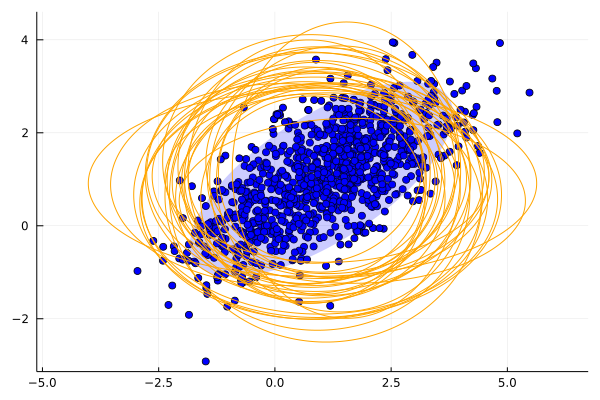

In [15]:
p = plot(legend = false, aspect_ratio = 1)
scatter!(X[1,:], X[2,:], color = :blue)
plotnormal!(μₓ, Σₓ, σ = 2, color = :blue, linecolor = :blue, linewidth = 0, fillalpha = 0.2)

μs = EFD.sample(model_diag.μ.posterior, 30)
#Σs = [inv(Λₗ) for Λₗ in EFD.sample(model.Λ.posterior, 30)]
Σs = [diagm(1 ./ λₗ) for λₗ in eachrow(hcat(EFD.sample.(getproperty.(model_diag.λ, :posterior), 30)...))]
for (μ, Σ) in zip(μs, Σs)
    plotnormal!(μ, Σ, σ = 2, color = :orange, linecolor = :orange, fillalpha = 0)
end

p

In [16]:
s1, s2, s3 = BayesianModels.statistics(model_full.Λ)
Σ = inv(EFD.matrix(s1, s2))

2×2 Matrix{Float64}:
 2.09717   0.973225
 0.973225  1.22961

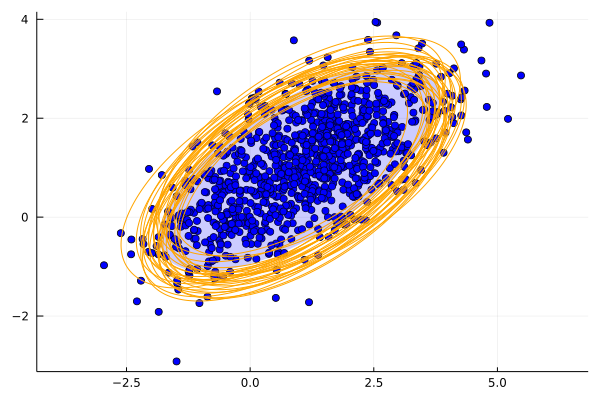

In [17]:
p = plot(legend = false, aspect_ratio = 1)
scatter!(X[1,:], X[2,:], color = :blue)
plotnormal!(μₓ, Σₓ, σ = 2, color = :blue, linecolor = :blue, linewidth = 0, fillalpha = 0.2)

μs = EFD.sample(model_full.μ.posterior, 30)
Σs = [inv(Λₗ) for Λₗ in EFD.sample(model_full.Λ.posterior, 30)]
Σs = [Σ for i in 1:30]
#Σs = [diagm(1 ./ λₗ) for λₗ in eachrow(hcat(EFD.sample.(getproperty.(model.λ, :posterior), 30)...))]
for (μ, Σ) in zip(μs, Σs)
    plotnormal!(μ, Σ, σ = 2, color = :orange, linecolor = :orange, fillalpha = 0)
end

p

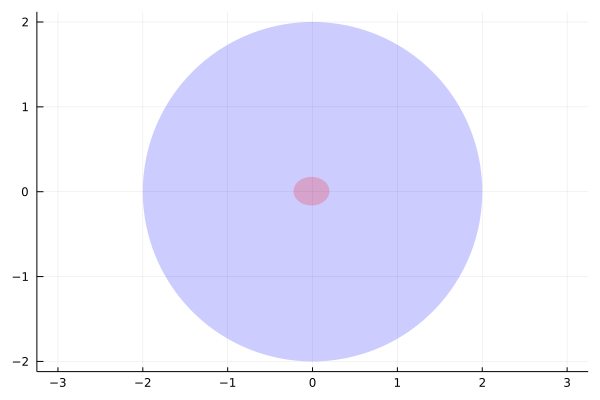

In [106]:
p = plot(legend = false, aspect_ratio = 1)
#scatter!(X[1,:], X[2,:], color = :blue)
plotnormal!(model_diag.μ.prior.μ, model_diag.μ.prior.Σ, σ = 2, color = :blue, linecolor = :blue, linewidth = 0, fillalpha = 0.2)
plotnormal!(model_diag.μ.posterior.μ, model_diag.μ.posterior.Σ, σ = 2, color = :red, linecolor = :red, linewidth = 0, fillalpha = 0.2)

p

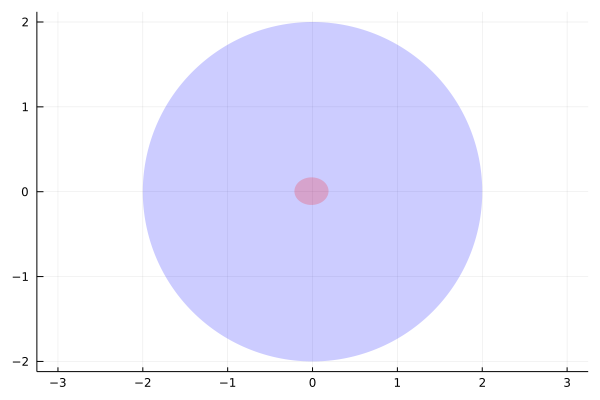

In [107]:
p = plot(legend = false, aspect_ratio = 1)
#scatter!(X[1,:], X[2,:], color = :blue)
plotnormal!(model_full.μ.prior.μ, model_full.μ.prior.Σ, σ = 2, color = :blue, linecolor = :blue, linewidth = 0, fillalpha = 0.2)
plotnormal!(model_full.μ.posterior.μ, model_full.μ.posterior.Σ, σ = 2, color = :red, linecolor = :red, linewidth = 0, fillalpha = 0.2)

p